# Advanced Programme in Deep Learning (Foundations and Applications)
## A Program by IISc and TalentSprint
### Assignment : IoT and Edge Devices - Quantization and Pruning of Neural Networks

### Learning Objectives:

At the end of the experiment, you will be able to:

*  understand about quantization
*  batchnorm folding
*  quantization aware training
*  understand role of pruning in minimization of the resource(power, memory, number of computations) requirements at test time
*  implement iterative pruning

## Dataset

#### Description

In this experiment, we will use the CIFAR-10 dataset from keras API. It consists of 60,000 colour images(32x32) in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.



Here are the classes in the dataset, as well as 10 random images from each:


<img src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Images/CIFAR10.png" alt="Drawing" height="350" width="440"/>


### Introduction

Deep learning has a growing history of successes, but heavy algorithms running on large graphical processing units are far from ideal. A relatively new family of deep learning methods called quantized neural networks have appeared in answer to this discrepancy. Quantization methods helps enabling efficient high-performance deep learning computation on small devices.

Moreover, Deep learning for classification tasks involves training the parameters of a neural network such that the algorithm learns to discern between object classes. This is achieved by feeding many images of labelled data to the neural network, while updating the parameters to increase performance on a smooth objective function. A drawback is that a large number of parameters are used, compared to more traditional algorithms.

Thus enters quantization as a method to bring the neural network to a reasonable size, while also achieving high performance accuracy. This is especially important for on-device applications, where the memory size and number of computations are necessarily limited. Quantization for deep learning is the process of approximating a neural network that uses floating-point numbers by a neural network of low bit width numbers. This dramatically reduces both the memory requirement and computational cost of using neural networks.


**Note:** Refer to the following to understand more about [Quantization](https://pytorch.org/docs/stable/quantization.html)

### Setup Steps:

In [1]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2240589" #@param {type:"string"}

In [2]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "9886499911" #@param {type:"string"}

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")

ipython = get_ipython()

notebook= "M3_AST_32_Quantization_&_Pruning_C" #name of the notebook

def setup():

    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer1() and getAnswer2() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer1" : Answer1, "answer2" : Answer2, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://dlfa-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer1():
  try:
    if not Answer1:
      raise NameError
    else:
      return Answer1
  except NameError:
    print ("Please answer Question 1")
    return None

def getAnswer2():
  try:
    if not Answer2:
      raise NameError
    else:
      return Answer2
  except NameError:
    print ("Please answer Question 2")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


### Importing required packages

In [4]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import time
import copy
import numpy as np

Defining helper functions to download and load the data

In [5]:
def set_random_seeds(random_seed=0):

    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

def prepare_dataloader(num_workers=8, train_batch_size=128, eval_batch_size=256):

    train_transform = transforms.Compose([   # Define transformations for train and test sets
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Loading train and test dataset
    train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)

    test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=test_transform)

    # A Sampler that randomly shuffled indices
    # A RandomSampler with a size and dtype for the stored indices.
    train_sampler = torch.utils.data.RandomSampler(train_set)

    # A Sampler that returns indices sequentially
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    # Loading the train and test dataloaders
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=train_batch_size,
        sampler=train_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=eval_batch_size,
        sampler=test_sampler, num_workers=num_workers)

    return train_loader, test_loader

### Initialization Code for Model Training

Source code for torchvision.models.resnet

In [6]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

In [7]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        # Rename relu to relu1
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()
        # Remember to use two independent ReLU for layer fusion.
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Use FloatFunctional for addition for quantization compatibility
        # out += identity
        out = self.skip_add.add(identity, out)
        out = self.relu2(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu1 = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # out += identity
        out = self.skip_add.add(identity, out)
        out = self.relu2(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # Each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

### Define Training Function

In [8]:
def train_model(model, train_loader, test_loader, device):

    # Learning rate
    learning_rate = 1e-2

    # No. of epochs
    num_epochs = 10

    # Loss function
    criterion = nn.CrossEntropyLoss()

    model.to(device)

    # It seems that SGD optimizer is better than Adam optimizer for ResNet18 training on CIFAR10.
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    for epoch in range(num_epochs):

        # Model Training
        model.train()

        running_loss = 0
        running_corrects = 0

        # Iterate through the dataloader
        for inputs, labels in train_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)

        # Model Evaluation
        model.eval()
        eval_loss, eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=device, criterion=criterion)

        print("Epoch: {:02d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(epoch, train_loss, train_accuracy, eval_loss, eval_accuracy))

    return model

### Define Test Function

In [9]:
def evaluate_model(model, test_loader, device, criterion=None):
    # Setting model mode to eval()
    model.eval()
    model.to(device)

    running_loss = 0
    running_corrects = 0

    # Iterating through the test dataloader
    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        if criterion is not None:
            loss = criterion(outputs, labels).item()
        else:
            loss = 0

        # Statistics
        running_loss += loss * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)

    return eval_loss, eval_accuracy

In [10]:
# Post-training quantization (PTQ) can reduce the memory footprint and latency of deep model inference, while still
# preserving the accuracy of the model, with only a small unlabeled calibration set and without the retraining on full training set.
# To calibrate a quantized model, current PTQ methods usually randomly select some unlabeled data from training set as calibration data.
def calibrate_model(model, loader, device=torch.device("cpu:0")):

    model.to(device)
    model.eval()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        _ = model(inputs)

# how to measure inference time correctly
# measure the time for model inference
def measure_inference_latency(model,
                              device,
                              input_size=(1, 3, 32, 32),
                              num_samples=100,
                              num_warmups=10):

    model.to(device)
    model.eval()

    x = torch.rand(size=input_size).to(device)

    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(x)
    # WAIT FOR GPU SYNC
    # torch.cuda.synchronize(). This line of code performs synchronization between the host and device (i.e., GPU and CPU),
    # so the time recording takes place only after the process running on the GPU is finished.
    # Waits for everything to finish running
    torch.cuda.synchronize()

    with torch.no_grad(): # No gradients calculation
        # Start time
        start_time = time.time()
        for _ in range(num_samples):
            _ = model(x)
            torch.cuda.synchronize()
        # Inference time took for the model to run the samples on GPU
        end_time = time.time()
    # Difference between start and end time
    elapsed_time = end_time - start_time
    # Average elapsed time
    elapsed_time_ave = elapsed_time / num_samples

    return elapsed_time_ave

### Save and load the models

In [11]:
# Save the the model
def save_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)

# Load the model using pytorch state dict
def load_model(model, model_filepath, device):

    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model

# Save an offline version of this module for use in a separate process.
# The saved module serializes all of the methods, submodules, parameters, and attributes of this module.
# https://pytorch.org/docs/stable/generated/torch.jit.save.html
def save_torchscript_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.jit.save(torch.jit.script(model), model_filepath)

# All previously saved modules, no matter their device, are first loaded onto CPU, and then are moved to the devices they were saved from
# https://pytorch.org/docs/stable/generated/torch.jit.load.html
def load_torchscript_model(model_filepath, device):

    model = torch.jit.load(model_filepath, map_location=device)

    return model

### Create the model

In [12]:
# Creating the model(without pretraining) with no of clasess
def create_model(num_classes=10):
    model = resnet18(num_classes=num_classes, pretrained=False)
    return model

def model_equivalence(model_1, model_2, device, rtol=1e-05, atol=1e-08, num_tests=100, input_size=(1,3,32,32)):

    model_1.to(device)
    model_2.to(device)

    for _ in range(num_tests):
        x = torch.rand(size=input_size).to(device)
        y1 = model_1(x).detach().cpu().numpy()
        y2 = model_2(x).detach().cpu().numpy()
        if np.allclose(a=y1, b=y2, rtol=rtol, atol=atol, equal_nan=False) == False:
            print("Model equivalence test sample failed: ")
            print(y1)
            print(y2)
            return False

    return True

### Quantization

* Quantization refers to techniques for doing both computations and memory accesses with lower precision data, usually **int8** compared to floating point implementations.
    
* Quantization leverages 8bit integer (int8) instructions to reduce the model size and run the inference faster (reduced latency).
    
* This enables providing quick inference from a trained model and even fitting it into the resources available on a mobile device.

* Quantization allows for siginificant performance gains!
    * Up to 4x reduction in model size.
    * Up to 2-4x reduction in memory bandwidth.
    * Up to 2-4x faster inference due to savings in memory bandwidth and faster compute with int8 arithmetic (the exact speed up varies depending on the hardware, the runtime, and the model).
    
* Quantization doesn't come without additional cost, as it means introducing approximations and the resulting networks have slightly less accuracy.
    
* These techniques attempt to minimize the gap between the full floating point accuracy and the quantized accuracy.

<center>
<img src="https://raw.githubusercontent.com/taldatech/ee046211-deep-learning/d94bdf2f6668d55de89d3c4b602b971e1fb1699c//assets/tut_compress_quant.png" width=750px/>
</center>


* Quantization is available in PyTorch in various flavors starting in version 1.3 and there are published quantized models for ResNet, ResNext, MobileNetV2, GoogleNet, InceptionV3 and ShuffleNetV2 in the PyTorch torchvision 0.5 library.

* Quantization is compatible with the rest of PyTorch: quantized models are traceable and scriptable. Quantized and floating point operations can be mixed in a model.

* Mapping of floating point tensors to quantized tensors is customizable with user defined observer/fake-quantization blocks. PyTorch provides default implementations that should work for most use cases.

* Currently the quantized models can only be run on CPU. However, it is possible to send the non-quantized parts of the model to a GPU.
    * GPU quantization is a work-in-progress, see PTQ (Post Training Quantization)



Now let's define a quantized version of our network.

For this, apply `torch.quantization.QuantStub()` and `torch.quantization.DequantStub()` to the inputs and outputs, respectively.

**Note**:  This step is to ask PyTorch to specifically collect quantization statistics for the inputs and outputs, respectively. Otherwise, since PyTorch collects quantization statistics for weights and activations by default, there will be problems for the input quantization and output dequantization, since there are no quantization statistics collected for them.

In [13]:
# Define a floating point model where some layers could be statically quantized
class QuantizedResNet18(nn.Module):
    def __init__(self, model_fp32):
        super(QuantizedResNet18, self).__init__()

        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()

        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()

        # FP32 model
        # FP32 is a FP32 Floating point data format for Deep Learning where data is represented as a 32-bit floating point number.
        self.model_fp32 = model_fp32

    def forward(self, x):

        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)

        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)

        return x

### Post training static quantization

Static quantization first feeds batches of data through the network and computes the resulting distributions of the different activations.
Static quantization quantizes the weights and activations of the model. It fuses activations into preceding layers wherever possible. It requires calibration with a representative dataset to determine optimal quantization parameters for activations. Post Training Quantization is typically used when both memory bandwidth and compute savings are important with CNNs being a typical use case. Static quantization is also known as **Post Training Quantization** or **PTQ**.

Steps involved in post training static quantization are :
1.  Load pretrained model or train a model.
2.  Fuse modules - combine operations/modules into a single module to obtain higher accuracy and performance. This is done using the fuse_modules() API, which takes in lists of modules to be fused. We currently support the following fusions: [Conv, Relu], [Conv, BatchNorm], [Conv, BatchNorm, Relu], [Linear, Relu]
3.  Evaluate model in calibration dataset.
4.  Calibration data is used to calibrate the model. It is usually a subset of training data.
5.  Calculate dynamic ranges of weights and activations in the network to calculate quantization parameters(scale and zero point).
6.  Quantize the network using quantization parameters and run the inference.


Apply quantization after training, quantization parameters are calculated based on sample calibration data)







In [14]:
random_seed = 0
num_classes = 10
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

model_dir = "saved_models"
model_filename = "resnet18_cifar10.pt"
quantized_model_filename = "resnet18_quantized_cifar10.pt"
model_filepath = os.path.join(model_dir, model_filename)
quantized_model_filepath = os.path.join(model_dir, quantized_model_filename)

set_random_seeds(random_seed=random_seed)

# Create an untrained model.
model = create_model(num_classes=num_classes)

train_loader, test_loader = prepare_dataloader(num_workers=8, train_batch_size=128, eval_batch_size=256)

# Train model.
model = train_model(model=model, train_loader=train_loader, test_loader=test_loader, device=cuda_device)

# Save model.
save_model(model=model, model_dir=model_dir, model_filename=model_filename)

# Load a pretrained model.
model = load_model(model=model, model_filepath=model_filepath, device=cuda_device)

# Move the model to CPU since static quantization does not support CUDA currently.
model.to(cpu_device)

# Make a copy of the model for layer fusion
fused_model = copy.deepcopy(model)

model.eval()

# The model has to be switched to evaluation mode before any layer fusion.
# Otherwise the quantization will not work correctly.
fused_model.eval()

100%|██████████| 170498071/170498071 [00:01<00:00, 101325186.35it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Epoch: 00 Train Loss: 1.707 Train Acc: 0.382 Eval Loss: 1.425 Eval Acc: 0.487
Epoch: 01 Train Loss: 1.365 Train Acc: 0.505 Eval Loss: 1.166 Eval Acc: 0.581
Epoch: 02 Train Loss: 1.176 Train Acc: 0.581 Eval Loss: 1.083 Eval Acc: 0.618
Epoch: 03 Train Loss: 1.059 Train Acc: 0.628 Eval Loss: 0.945 Eval Acc: 0.670
Epoch: 04 Train Loss: 0.968 Train Acc: 0.658 Eval Loss: 0.872 Eval Acc: 0.691
Epoch: 05 Train Loss: 0.900 Train Acc: 0.683 Eval Loss: 0.836 Eval Acc: 0.713
Epoch: 06 Train Loss: 0.852 Train Acc: 0.700 Eval Loss: 0.914 Eval Acc: 0.705
Epoch: 07 Train Loss: 0.814 Train Acc: 0.711 Eval Loss: 0.850 Eval Acc: 0.715
Epoch: 08 Train Loss: 0.773 Train Acc: 0.728 Eval Loss: 0.800 Eval Acc: 0.717
Epoch: 09 Train Loss: 0.741 Train Acc: 0.739 Eval Loss: 0.737 Eval Acc: 0.742


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

**Fusing batchnorm with convolution saves extra computation at time of inference. It is also known as `Batchnorm folding`**.

We update the weight and bias  of convolution layer before batchnorm to simulate the effect of batchnorm.

Equations (5) & (6) denote the same  

<br>

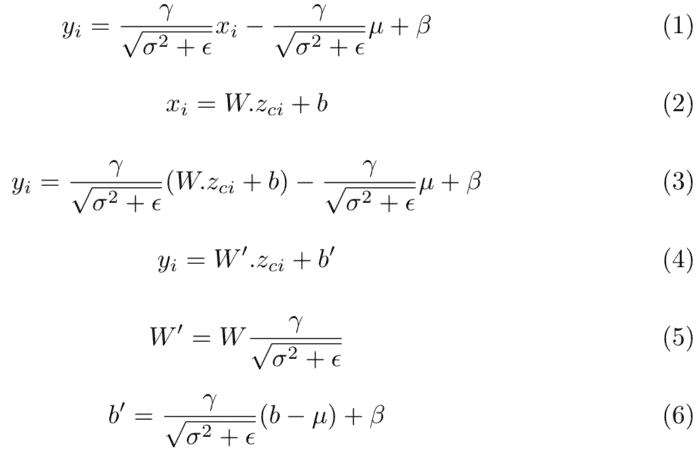


In [15]:
# Fuse the model in place rather manually.
# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
# https://pytorch.org/docs/stable/generated/torch.quantization.fuse_modules.html
# It returns model with fused modules. A new copy is created if inplace=True.
fused_model = torch.quantization.fuse_modules(fused_model, [["conv1", "bn1", "relu"]], inplace=True)
for module_name, module in fused_model.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu1"], ["conv2", "bn2"]], inplace=True)
            for sub_block_name, sub_block in basic_block.named_children():
                if sub_block_name == "downsample":
                    torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)

# Print FP32 model.
print(model)

# Print fused model.
print(fused_model)

# Model and fused model should be equivalent.
assert model_equivalence(model_1=model, model_2=fused_model, device=cpu_device, rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,3,32,32)), "Fused model is not equivalent to the original model!"

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

* Converting networks to use both integer arithmetic and int8 memory accesses can improve the latency performance.
    
* Static quantization first feeds batches of data through the network and computes the resulting distributions of the different activations.
    * This is done by inserting “observer” modules at different points that record these distributions.
    
* This information is used to determine how specifically the different activations should be quantized at inference time.
        
* A simple technique would be to simply divide the entire range of activations into 256 levels, but PyTorch supports more sophisticated methods as well.
    
* This step allows to pass quantized values between operations instead of converting these values to floats - and then back to ints - between every operation, resulting in a significant speed-up.
    
* **Optimizing static quantization includes:**
    * **Observers:** observer modules specify how statistics are collected prior to quantization to try out more advanced methods to quantize the data.

    * **Operator fusion:** fuse multiple operations into a single operation, saving on memory access while also improving the operation’s numerical accuracy.
    
    * **Per-channel quantization:** we can independently quantize weights for each output channel in a convolution/linear layer, which can lead to higher accuracy with almost the same speed.


Now, we will perform the following:

*  Specify quantization configurations, such as symmetric quantization or asymmetric quantization, etc.
*  Prepare quantization model for post-training calibration.
*  Run post-training calibration.
*  Convert the calibrated floating point model to quantized integer model.
*  Verify accuracies and inference performance gain.
*  Save the quantized integer model.

In [16]:
# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
quantized_model = QuantizedResNet18(model_fp32=fused_model)

# Using un-fused model will fail.
# Because there is no quantized layer implementation for a single batch normalization layer.
# quantized_model = QuantizedResNet18(model_fp32=model) # This will not work
# Select quantization schemes from
# https://pytorch.org/docs/stable/quantization-support.html
# When preparing a quantized model, it is necessary to ensure that qconfig and the engine used for
# quantized computations match the backend on which the model will be executed. The qconfig controls the type of
# observers used during the quantization passes. The qengine controls whether fbgemm or qnnpack specific packing
# function is used when packing weights for linear and convolution functions and modules.
quantization_config = torch.quantization.get_default_qconfig("fbgemm")

# Custom quantization configurations
# quantization_config = torch.quantization.default_qconfig
# quantization_config = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8), weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))

quantized_model.qconfig = quantization_config

# Print quantization configurations
print(quantized_model.qconfig)

torch.quantization.prepare(quantized_model, inplace=True)

# Use training data for calibration.
calibrate_model(model=quantized_model, loader=train_loader, device=cpu_device)

quantized_model = torch.quantization.convert(quantized_model, inplace=True)

# Using high-level static quantization wrapper
# The above steps, including torch.quantization.prepare, calibrate_model, and torch.quantization.convert, are also equivalent to
# quantized_model = torch.quantization.quantize(model=quantized_model, run_fn=calibrate_model, run_args=[train_loader], mapping=None, inplace=False)

quantized_model.eval()

# Print the quantized model.
print(quantized_model)

# Save the quantized model.
save_torchscript_model(model=quantized_model, model_dir=model_dir, model_filename=quantized_model_filename)

# Load the quantized model.
quantized_jit_model = load_torchscript_model(model_filepath=quantized_model_filepath, device=cpu_device)

_, fp32_eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=cpu_device, criterion=None)
_, int8_eval_accuracy = evaluate_model(model=quantized_jit_model, test_loader=test_loader, device=cpu_device, criterion=None)

# Skip this assertion since the values might deviate a lot.
# assert model_equivalence(model_1=model, model_2=quantized_jit_model, device=cpu_device, rtol=1e-01, atol=1e-02, num_tests=100, input_size=(1,3,32,32)), "Quantized model deviates from the original model too much!"

print("FP32 evaluation accuracy: {:.3f}".format(fp32_eval_accuracy))
print("INT8 evaluation accuracy: {:.3f}".format(int8_eval_accuracy))

fp32_cpu_inference_latency = measure_inference_latency(model=model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
int8_cpu_inference_latency = measure_inference_latency(model=quantized_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
int8_jit_cpu_inference_latency = measure_inference_latency(model=quantized_jit_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
fp32_gpu_inference_latency = measure_inference_latency(model=model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)

print("FP32 CPU Inference Latency: {:.2f} ms / sample".format(fp32_cpu_inference_latency * 1000))
print("FP32 CUDA Inference Latency: {:.2f} ms / sample".format(fp32_gpu_inference_latency * 1000))
print("INT8 CPU Inference Latency: {:.2f} ms / sample".format(int8_cpu_inference_latency * 1000))
print("INT8 JIT CPU Inference Latency: {:.2f} ms / sample".format(int8_jit_cpu_inference_latency * 1000))

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
QuantizedResNet18(
  (quant): Quantize(scale=tensor([0.0408]), zero_point=tensor([60]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model_fp32): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.06955798715353012, zero_point=0, padding=(3, 3))
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.039114080369472504, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu1): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), str

### Quantization aware training
Static quantization allows the user to generate quantized integer model that is highly efficient during inference. However, sometimes, even with careful post-training calibration, the model accuracies might be sacrificed to some extent that is not acceptable. If this is the case, post-training calibration is not sufficient to generate a quantized integer model. We would have train the model in a way so that the quantization effect has been taken into account. Quantization aware training is capable of modeling the quantization effect during training.

The mechanism of quantization aware training is simple, it places fake quantization modules, i.e., all weights and activations are “fake quantized” during both the forward and backward passes of training: quantization and dequantization modules, at the places where quantization happens during floating-point model to quantized integer model conversion, to simulate the effects of clamping and rounding brought by integer quantization. The fake quantization modules will also monitor scales and zero points of the weights and activations. Once the quantization aware training is finished, the floating point model could be converted to quantized integer model immediately using the information stored in the fake quantization modules.

In [17]:
def train_model_qat(model, train_loader, test_loader, device, learning_rate=1e-1, num_epochs=5):

    criterion = nn.CrossEntropyLoss()

    model.to(device)

    # It seems that SGD optimizer is better than Adam optimizer for ResNet18 training on CIFAR10.
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1, last_epoch=-1)

    # optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # Evaluation
    # model.eval()
    # eval_loss, eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=device, criterion=criterion)
    # print("Epoch: {:02d} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(-1, eval_loss, eval_accuracy))

    for epoch in range(num_epochs):

        # Training
        model.train()

        if epoch > 3:
        # Freeze quantizer parameters
          model.apply(torch.quantization.disable_observer)

        if epoch > 2:
        # Freeze batch norm mean and variance estimates
          model.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

        running_loss = 0
        running_corrects = 0

        for inputs, labels in train_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)

        # Evaluation
        model.eval()
        eval_loss, eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=device, criterion=criterion)

        # Set learning rate scheduler
        scheduler.step()

        print("Epoch: {:03d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(epoch, train_loss, train_accuracy, eval_loss, eval_accuracy))

    return model

In [18]:
quantized_model_filename = "resnet18_QAT_quantized_cifar10.pt"
quantized_model_filepath = os.path.join(model_dir, quantized_model_filename)

set_random_seeds(random_seed=random_seed)

# Create an untrained model.
model = create_model(num_classes=num_classes)

train_loader, test_loader = prepare_dataloader(num_workers=8, train_batch_size=128, eval_batch_size=256)

# # Load a pretrained model.
model = load_model(model=model, model_filepath=model_filepath, device=cuda_device)

# Move the model to CPU since static quantization does not support CUDA currently.
model.to(cpu_device)

# Make a copy of the model for layer fusion
fused_model = copy.deepcopy(model)

# Model and fused model should be equivalent.
model.eval()
fused_model.eval()


# Fuse the model in place rather manually.
fused_model = torch.quantization.fuse_modules(fused_model, [["conv1", "bn1", "relu"]], inplace=True)
for module_name, module in fused_model.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu1"], ["conv2", "bn2"]], inplace=True)
            for sub_block_name, sub_block in basic_block.named_children():
                if sub_block_name == "downsample":
                    torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)

# Print FP32 model.
print(model)

# Print fused model.
print(fused_model)

assert model_equivalence(model_1=model, model_2=fused_model, device=cpu_device, rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,3,32,32)), "Fused model is not equivalent to the original model!"

Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
      (relu2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d

Prepare the model for quantization aware training.

In [19]:
# Prepare the model for quantization aware training. This inserts observers in
# the model that will observe activation tensors during calibration.
quantized_model = QuantizedResNet18(model_fp32=fused_model)

# Using un-fused model will fail.
# Because there is no quantized layer implementation for a single batch normalization layer.
# quantized_model = QuantizedResNet18(model_fp32=model)
# Select quantization schemes from
# https://pytorch.org/docs/stable/quantization-support.html
quantization_config = torch.quantization.get_default_qconfig("fbgemm")

# Custom quantization configurations
# quantization_config = torch.quantization.default_qconfig
# quantization_config = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8), weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))

quantized_model.qconfig = quantization_config

# Print quantization configurations
print(quantized_model.qconfig)

# https://pytorch.org/docs/stable/_modules/torch/quantization/quantize.html#prepare_qat
torch.quantization.prepare_qat(quantized_model, inplace=True)

# # Use training data for calibration.
print("Training QAT Model...")
quantized_model.train()

train_model_qat(model=quantized_model, train_loader=train_loader, test_loader=test_loader, device=cuda_device, learning_rate=1e-3, num_epochs=5)
quantized_model.to(cpu_device)

# Using high-level static quantization wrapper
# The above steps, including torch.quantization.prepare, calibrate_model, and torch.quantization.convert, are also equivalent to
# quantized_model = torch.quantization.quantize_qat(model=quantized_model, run_fn=train_model, run_args=[train_loader, test_loader, cuda_device], mapping=None, inplace=False)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, fuses modules where appropriate,
# and replaces key operators with quantized implementations.
quantized_model = torch.quantization.convert(quantized_model, inplace=True)
quantized_model.eval()

# Print quantized model.
print(quantized_model)

# Save quantized model.
save_torchscript_model(model=quantized_model, model_dir=model_dir, model_filename=quantized_model_filename)

# Load quantized model.
quantized_jit_model = load_torchscript_model(model_filepath=quantized_model_filepath, device=cpu_device)

_, fp32_eval_accuracy = evaluate_model(model=model, test_loader=test_loader, device=cpu_device, criterion=None)
_, int8_eval_accuracy = evaluate_model(model=quantized_jit_model, test_loader=test_loader, device=cpu_device, criterion=None)

# Skip this assertion since the values might deviate a lot.
# assert model_equivalence(model_1=model, model_2=quantized_jit_model, device=cpu_device, rtol=1e-01, atol=1e-02, num_tests=100, input_size=(1,3,32,32)), "Quantized model deviates from the original model too much!"

print("QAT FP32 evaluation accuracy: {:.3f}".format(fp32_eval_accuracy))
print("QAT INT8 evaluation accuracy: {:.3f}".format(int8_eval_accuracy))

fp32_cpu_inference_latency = measure_inference_latency(model=model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
int8_cpu_inference_latency = measure_inference_latency(model=quantized_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
int8_jit_cpu_inference_latency = measure_inference_latency(model=quantized_jit_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
fp32_gpu_inference_latency = measure_inference_latency(model=model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)

print("QAT FP32 CPU Inference Latency: {:.2f} ms / sample".format(fp32_cpu_inference_latency * 1000))
print("QAT FP32 CUDA Inference Latency: {:.2f} ms / sample".format(fp32_gpu_inference_latency * 1000))
print("QAT INT8 CPU Inference Latency: {:.2f} ms / sample".format(int8_cpu_inference_latency * 1000))
print("QAT INT8 JIT CPU Inference Latency: {:.2f} ms / sample".format(int8_jit_cpu_inference_latency * 1000))

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Training QAT Model...
Epoch: 000 Train Loss: 0.658 Train Acc: 0.768 Eval Loss: 0.689 Eval Acc: 0.761
Epoch: 001 Train Loss: 0.636 Train Acc: 0.775 Eval Loss: 0.679 Eval Acc: 0.763
Epoch: 002 Train Loss: 0.615 Train Acc: 0.781 Eval Loss: 0.674 Eval Acc: 0.763
Epoch: 003 Train Loss: 0.605 Train Acc: 0.785 Eval Loss: 0.659 Eval Acc: 0.770
Epoch: 004 Train Loss: 0.602 Train Acc: 0.786 Eval Loss: 0.665 Eval Acc: 0.771
QuantizedResNet18(
  (quant): Quantize(scale=tensor([0.0408]), zero_point=tensor([60]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model_fp32): ResNet(
    (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.0701265037059784, zero_point=0, padding=(3, 3))
    (bn1): Identity()
  

### Pruning using PyTorch

Deep Learning models these days require a significant amount of computing, memory, and power which becomes a bottleneck in the conditions where we need real-time inference or to run models on edge devices and browsers with limited computational resources. Energy efficiency is a major concern for current deep learning models. One of the methods for tackling this efficiency is enabling inference efficiency.

**Larger Model => More Memory References => More Energy**

Pruning is one of the methods for inference to efficiently produce models smaller in size, more memory-efficient, more power-efficient and faster at inference with minimal loss in accuracy, other such techniques being weight sharing and quantization. Out of several aspects that deep learning takes as an inspiration from the area of Neuroscience. Moreover, pruning in deep learning is also a biologically inspired concept. Now, let us begin with it's implementation.

<br>
<center>
<img src="https://miro.medium.com/max/720/1*nicFUkeUpWMW1w_hUVtZiw.png" width=650px/>
</center>


### Importing required libraries

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd

### Effects of Pruning Neural Nets



Pruning is deleting connections in a neural net in order to improve generalization and reduce computational resources.
Two most common type of pruning are :

1.   Weight-pruning
2.   Unit-pruning

In **weight pruning**  the largest weights by absolute value are set to zero.
While in **unit-pruning** , the smallest neurons are set to zero by a vector-wise metric like **L2-norm**.

Here, we examine the relationship between pruning and accuracy on a vanilla neural net. Before running any experiments, we hypothesize that accuracy for the pruned neural net will slightly rise (due to the regularization), and then have a negative linear correlation with the amount pruned. we also hypothesize that unit-pruning, in deleting entire neurons instead of individual weights, will have a more dramatic negative effect than weight-pruning.

First, let's load, normalize, and visualize the MNIST dataset.



In [21]:
def load_MNIST():
  """Function to load and normalize MNIST data"""
  train = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  test = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ]))
  print("MNIST datset loaded and normalized.")
  train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=100)
  test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=False, batch_size=100)
  print("PyTorch DataLoaders loaded.")
  return train, test, train_loader, test_loader

In [22]:
def visualize_MNIST(train_loader):
  """Function to visualize data given a DataLoader object"""
  dataiter = iter(train_loader)
  images, labels = next(dataiter)
  print("image shape:", images.shape, "\n label shape:", labels.shape)
  # visualize data
  fig, ax = plt.subplots(2,5)
  for i, ax in enumerate(ax.flatten()):
      im_idx = np.argwhere(labels == i)[0][0]
      plottable_image = images[im_idx].squeeze()
      ax.imshow(plottable_image)

100%|██████████| 9912422/9912422 [00:00<00:00, 118241470.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88809159.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32426651.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21190799.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

MNIST datset loaded and normalized.
PyTorch DataLoaders loaded.
image shape: torch.Size([100, 1, 28, 28]) 
 label shape: torch.Size([100])


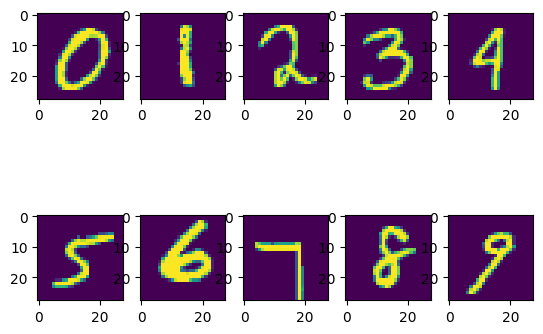

In [23]:
# load and visualize MNIST
train, test, train_loader, test_loader = load_MNIST()
visualize_MNIST(train_loader)

### Build Vanilla Neural Network

Now let's build a vanilla neural net with four hidden layers without pruning.

We'll keep things simple and leave out biases, convolutions, and pooling.

In [24]:
class Net(nn.Module):
  """A non-sparse neural network with four hidden fully-connected layers"""

  def __init__(self):
    super(Net,self).__init__()
    self.input_layer = nn.Linear(784, 1000, bias=False)
    self.hidden1_layer = nn.Linear(1000, 1000, bias=False)
    self.hidden2_layer = nn.Linear(1000, 500, bias=False)
    self.hidden3_layer = nn.Linear(500, 200, bias=False)
    self.hidden4_layer = nn.Linear(200, 10, bias=False)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    x = self.hidden1_layer(x)
    x = F.relu(x)
    x = self.hidden2_layer(x)
    x = F.relu(x)
    x = self.hidden3_layer(x)
    x = F.relu(x)
    x = self.hidden4_layer(x)
    output = F.log_softmax(x, dim=1)

    return output

### Model Training

Let's train our vanilla neural net.

In [25]:
def train(model, train_loader, epochs=3, learning_rate=0.001):
  """Function to train a neural net"""

  lossFunction = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  time0 = time()
  total_samples = 0

  for e in range(epochs):
    print("Starting epoch", e)
    total_loss = 0

    for idx, (images,labels) in enumerate(train_loader):
      images = images.view(images.shape[0],-1) # flatten
      optimizer.zero_grad() # zero out the gradients
      output = model(images) # forward pass
      loss = lossFunction(output,labels) # calculate loss
      loss.backward() # backpropagate
      optimizer.step() # update weights

      total_samples += labels.size(0)
      # Compute the loss
      total_loss += loss.item()

      if idx % 100 == 0:
        print("Running loss:", total_loss)

  final_time = (time()-time0)/60
  print("Model trained in ", final_time, "minutes on ", total_samples, "samples")

In [26]:
model = Net()
train(model, train_loader)

Starting epoch 0
Running loss: 2.301912784576416
Running loss: 74.10412240028381
Running loss: 106.3925986289978
Running loss: 132.81659303605556
Running loss: 155.05538753420115
Running loss: 176.53194750100374
Starting epoch 1
Running loss: 0.1646682322025299
Running loss: 16.16992173716426
Running loss: 31.860308431088924
Running loss: 47.339561343193054
Running loss: 62.5030517950654
Running loss: 75.86018631234765
Starting epoch 2
Running loss: 0.2028014063835144
Running loss: 12.988306557759643
Running loss: 24.516527350991964
Running loss: 35.20362804085016
Running loss: 46.668342024087906
Running loss: 57.74598481506109
Model trained in  2.1640615304311117 minutes on  180000 samples


### Model Testing

Now we'll test our vanilla neural net.

In [27]:
def test(model, test_loader):
  """Test neural net"""

  correct = 0
  total = 0

  with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
      images = images.view(images.shape[0],-1) # flatten
      output = model(images) # Forward pass
      values, indices = torch.max(output.data, 1) # maximum probability of the predictions
      total += labels.size(0)
      correct += (labels == indices).sum().item()

    # Accuracy of model
    acc = correct / total * 100
    # print("Accuracy: ", acc, "% for ", total, "training samples")

  return acc

In [28]:
acc = test(model, test_loader)
print("The accuracy of our vanilla NN is", acc, "%")

The accuracy of our vanilla NN is 96.63000000000001 %


A ~96% accuracy for our vanilla neural network seems reasonable. Now let's do some weight and unit pruning.

### Define function for weight pruning

In [29]:
def sparsify_by_weights(model, k):

  """Function that takes un-sparsified neural net and does weight-pruning
  by k sparsity"""

  # make copy of original neural net
  sparse_m = copy.deepcopy(model)

  with torch.no_grad():
    for idx, i in enumerate(sparse_m.parameters()):
      if idx == 4: # skip last layer of 5-layer neural net
        break
      # change tensor to numpy format, then set appropriate number of smallest weights to zero
      layer_copy = torch.flatten(i)
      layer_copy = layer_copy.detach().numpy()
      indices = abs(layer_copy).argsort() # get indices of smallest weights by absolute value
      indices = indices[:int(len(indices)*k)] # get k fraction of smallest indices
      layer_copy[indices] = 0

      # change weights of model
      i = torch.from_numpy(layer_copy)

  return sparse_m

### Define function for unit pruning

In [30]:
def l2(array):
  return np.sqrt(np.sum([i**2 for i in array]))

def sparsify_by_unit(model, k):
  """Creates a k-sparsity model with unit-level pruning that sets columns with smallest L2 to zero."""

  # make copy of original neural net
  sparse_m = copy.deepcopy(model)

  for idx, i in enumerate(sparse_m.parameters()):
    if idx == 4: # skip last layer of 5-layer neural net
      break
    layer_copy = i.detach().numpy()
    indices = np.argsort([l2(i) for i in layer_copy])
    indices = indices[:int(len(indices)*k)]
    layer_copy[indices,:] = 0
    i = torch.from_numpy(layer_copy)

  return sparse_m

In [31]:
def get_pruning_accuracies(model, prune_type):
  """ Takes a model and prune type ("weight" or "unit") and returns a DataFrame of pruning accuracies for given sparsities."""

  df = pd.DataFrame({"sparsity": [], "accuracy": []})
  sparsities = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80]#, 0.90, 0.95, 0.97, 0.99]

  for s in sparsities:
    if prune_type == "weight":
      new_model = sparsify_by_weights(model, s)
    elif prune_type == "unit":
      new_model = sparsify_by_unit(model, s)
    else:
      print("Must specify prune-type.")
      return
    acc = test(new_model, test_loader)
    df = df.append({"sparsity": s, "accuracy": acc}, ignore_index=True)

  return df,new_model

### Results

In [32]:
df_weight,weight_pruned_model = get_pruning_accuracies(model, "weight")
df_unit,unit_pruned_model = get_pruning_accuracies(model, "unit")

print("Accuracies for Weight Pruning")
print(df_weight)

print()

print("Accuracies for Unit Pruning")
print(df_unit)

Accuracies for Weight Pruning
   sparsity  accuracy
0      0.00     96.63
1      0.25     96.73
2      0.50     96.64
3      0.60     96.58
4      0.70     96.76
5      0.80     95.07

Accuracies for Unit Pruning
   sparsity  accuracy
0      0.00     96.63
1      0.25     96.61
2      0.50     96.46
3      0.60     95.92
4      0.70     93.21
5      0.80     74.05


Now let's visualize weights and compare it with unpruned model.

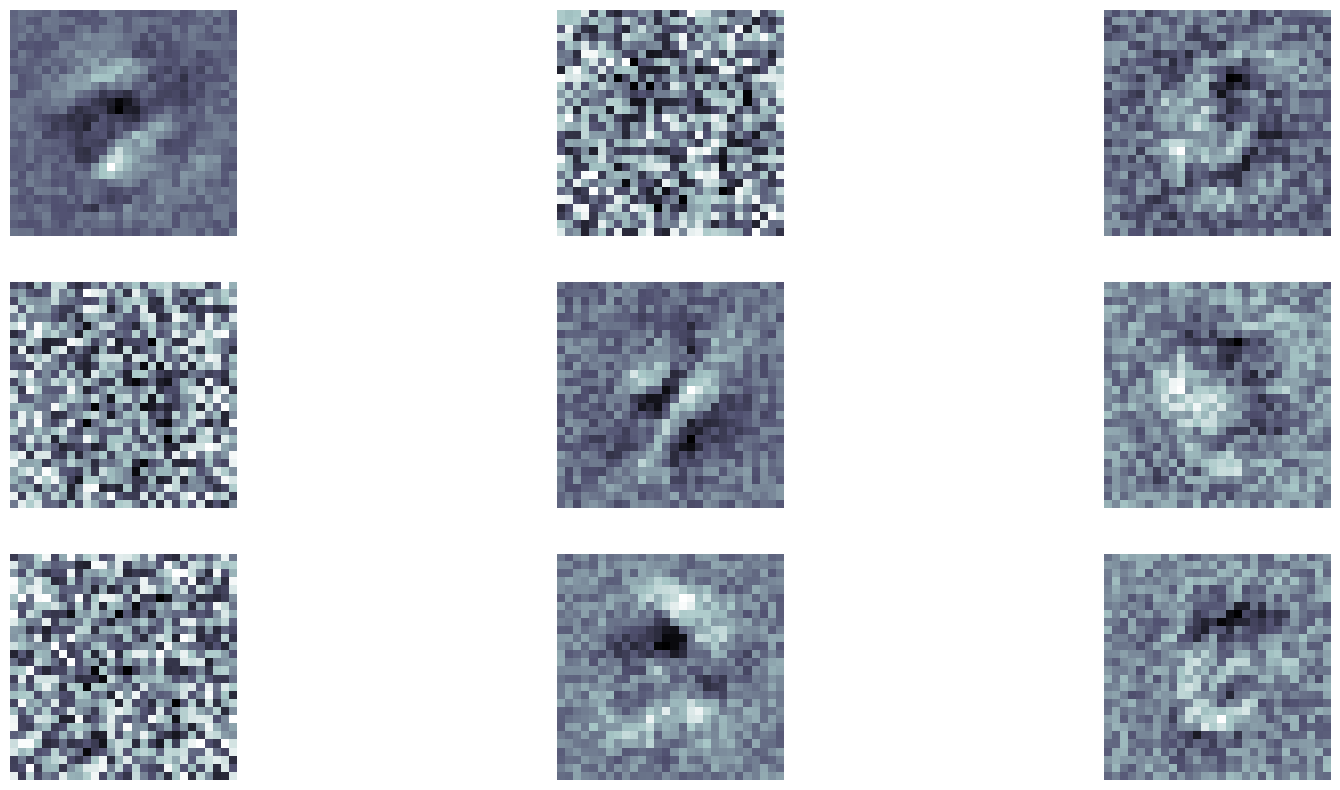

In [33]:
import matplotlib.pyplot as plt
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')
N_WEIGHTS = 9

weights = model.input_layer.weight.data

plot_weights(weights, N_WEIGHTS)

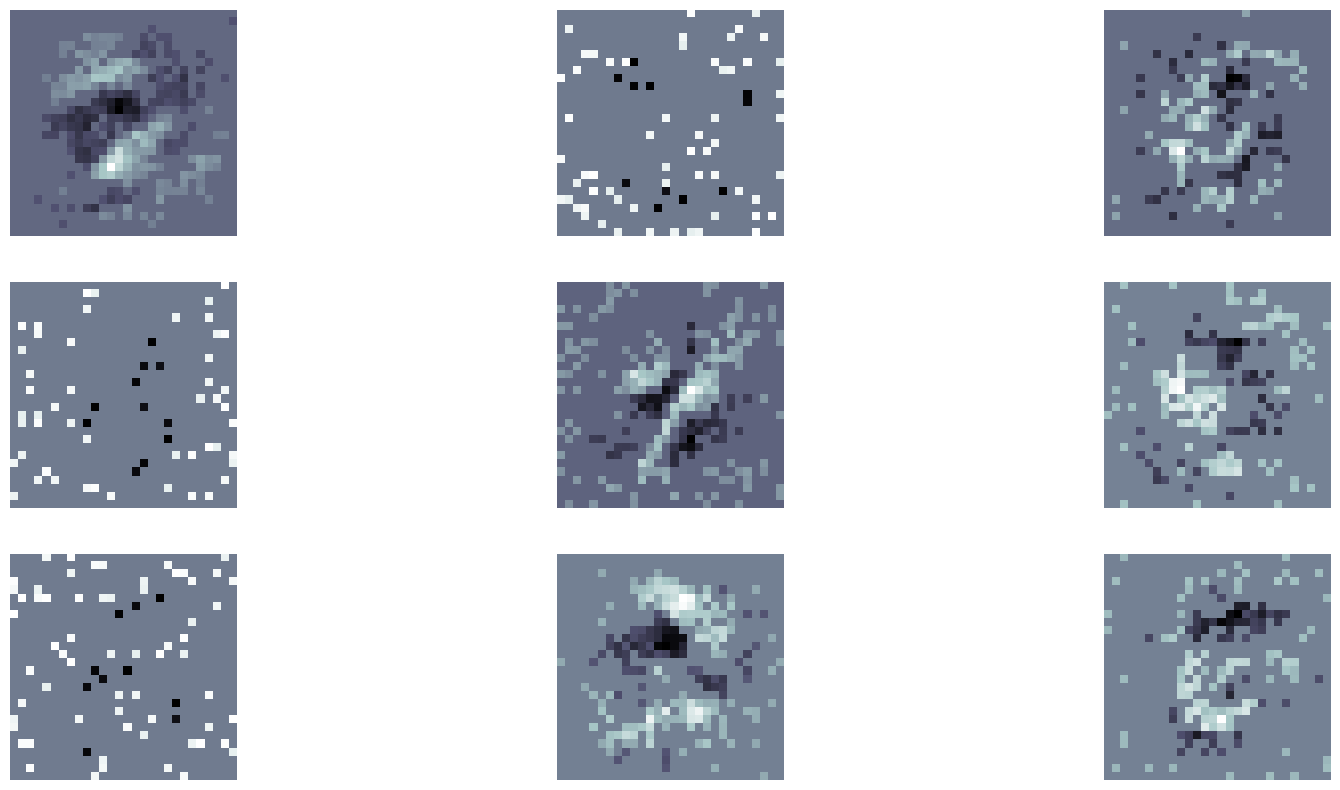

In [34]:
# Lets visualize weights after pruning
# Weight pruning at 80 percent sparsity
N_WEIGHTS = 9

weights = weight_pruned_model.input_layer.weight.data

plot_weights(weights, N_WEIGHTS)

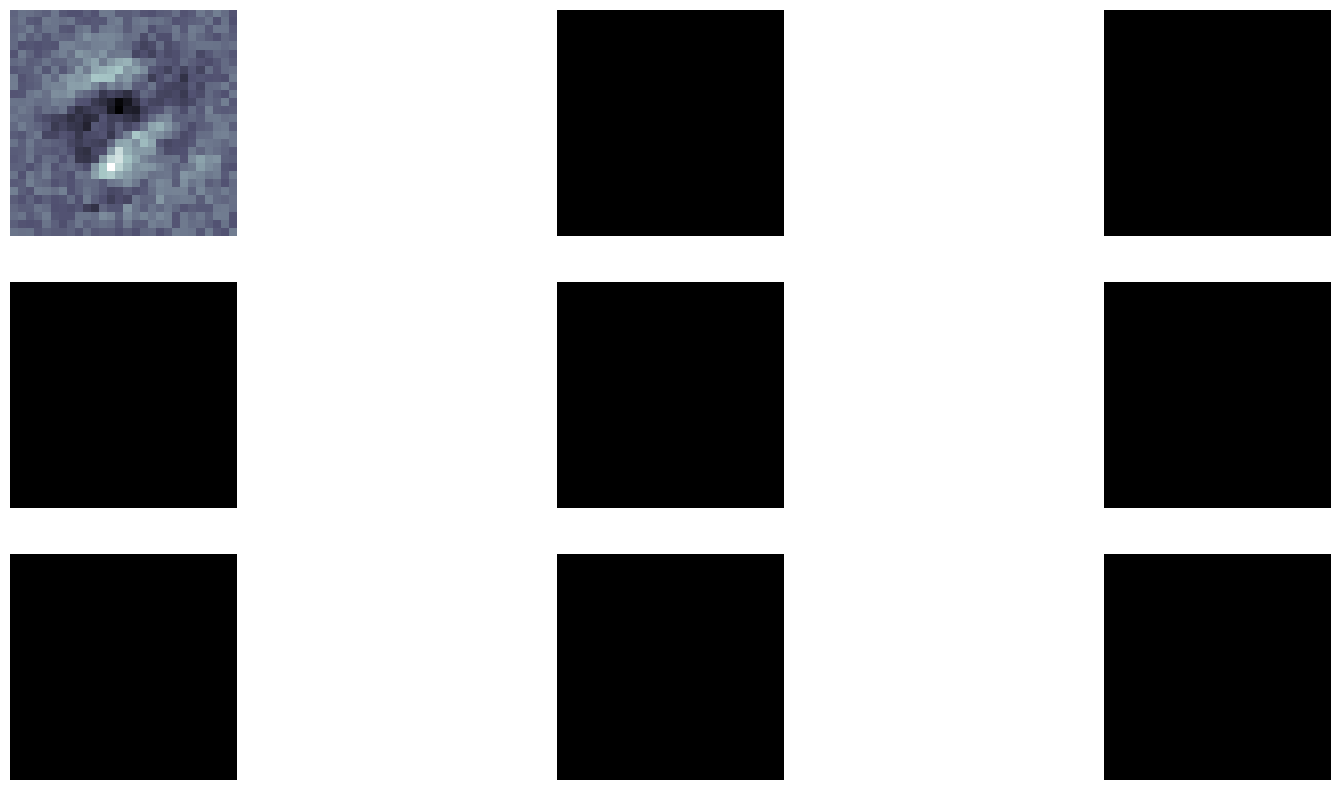

In [35]:
# Lets visualize weights after pruning

# Unit pruning at 80 percent sparsity
N_WEIGHTS = 9

weights = unit_pruned_model.input_layer.weight.data

plot_weights(weights, N_WEIGHTS)

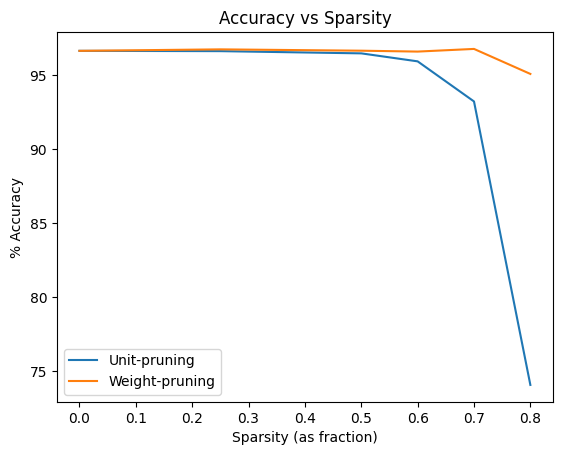

In [36]:
plt.figure()
plt.title("Accuracy vs Sparsity")
plt.plot(df_unit["sparsity"], df_unit["accuracy"], label="Unit-pruning")
plt.plot(df_weight["sparsity"], df_weight["accuracy"], label="Weight-pruning")
plt.xlabel("Sparsity (as fraction)")
plt.ylabel("% Accuracy")
plt.legend()

### Iterative Pruning

Unlike One-time  pruning + fine-tuning which achieves the desired prune rate by pruning and fine-tuning once, multi-time iterative pruning + fine-tuning achieves the desired prune rate by pruning and fine-tuning multiple-times.

For example, to achieve the desired prune rate of
98
%
, we could run pruning and fine-tuning for many iterations, achieving prune rate of
30
%
,
50
%
,
66
%
,
76
%
,
⋯
,
98
%
 in each iteration.

 So basically we **train for some epochs, prune slightly and train again**. We repeat this process until desired sparsity is reached. In this case we use masks (either 0 or 1 ) per layer to get remember the indices of pruned elements.

In [37]:
class MaskedLinear(nn.Linear):
	""" same as Linear except has a configurable mask on the weights """

	def __init__(self, in_features, out_features, bias=True):
		super().__init__(in_features, out_features, bias)
		self.register_buffer('mask', torch.ones(out_features, in_features))

	def forward(self, input):
		return F.linear(input, self.mask * self.weight, self.bias)

class MaskNet(nn.Module):
  """A non-sparse neural network with four hidden fully-connected layers"""

  def __init__(self):
    super(MaskNet,self).__init__()
    self.input_layer = MaskedLinear(784, 1000, bias=False)
    self.hidden1_layer = MaskedLinear(1000, 1000, bias=False)
    self.hidden2_layer = MaskedLinear(1000, 500, bias=False)
    self.hidden3_layer = MaskedLinear(500, 200, bias=False)
    self.hidden4_layer = MaskedLinear(200, 10, bias=False)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    x = self.hidden1_layer(x)
    x = F.relu(x)
    x = self.hidden2_layer(x)
    x = F.relu(x)
    x = self.hidden3_layer(x)
    x = F.relu(x)
    x = self.hidden4_layer(x)
    output = F.log_softmax(x, dim=1)

    return output

In [38]:
masked_model = MaskNet()
train(masked_model, train_loader)

Starting epoch 0
Running loss: 2.3034982681274414
Running loss: 76.18879228830338
Running loss: 110.2517869323492
Running loss: 135.149330586195
Running loss: 156.996777869761
Running loss: 179.48454108834267
Starting epoch 1
Running loss: 0.26755964756011963
Running loss: 16.575115531682968
Running loss: 32.03917044773698
Running loss: 47.042292814701796
Running loss: 61.75750296190381
Running loss: 76.32663689181209
Starting epoch 2
Running loss: 0.04951794072985649
Running loss: 12.452651092782617
Running loss: 24.6075307559222
Running loss: 36.777904810383916
Running loss: 48.71636760979891
Running loss: 58.79316691868007
Model trained in  2.3814589937527972 minutes on  180000 samples


In [40]:
acc = test(masked_model, test_loader)
print("The accuracy of our masked vanilla NN is", acc, "%")

The accuracy of our masked vanilla NN is 96.28 %


In [41]:
def gen_prune_rate(max_prune_rate=0.5,start_epoch=0,num_prune_epochs=8,total_epoch=30):
    """Function to calculate pruning ratio for different pruning epochs"""
    final_prune_epoch = int(0.8*total_epoch) # change ratio to change final prune epoch
    #num_prune_epochs = 8
    prune_rates = [max_prune_rate*(1 - (1 - (i / num_prune_epochs))**3)
                    for i in range(num_prune_epochs)]
    prune_rates[-1] = max_prune_rate
    prune_epochs = np.linspace(start_epoch, final_prune_epoch, num_prune_epochs).astype('i').tolist()

    return prune_rates,prune_epochs

def prune_iterative(model, prune_percentage):
  """Function that takes un-sparsified neural net and does weight-pruning
  by k sparsity"""

  # make copy of original neural net
  sparse_m = copy.deepcopy(model)
  linear_layers = [m for m in sparse_m.modules() if isinstance(m,MaskedLinear) ]
  with torch.no_grad():
    for idx,layer in enumerate(linear_layers):
      if idx == 4: # skip last layer of 5-layer neural net
        break
      # change tensor to numpy format, then set appropriate number of smallest weights to zero
      layer_mask = torch.ones(len(layer.weight.reshape(-1)))
      layer_copy = torch.flatten(layer.weight)
      layer_copy = layer_copy.detach().numpy()
      indices = abs(layer_copy).argsort() # get indices of smallest weights by absolute value
      indices = indices[:int(len(indices)*prune_percentage)] # get k fraction of smallest indices
      layer_mask[indices] = 0

      # change masks of the layer
      layer.mask = layer_mask.reshape(layer.weight.shape)


  return sparse_m

def train_iterative_prune(model, train_loader, epochs=10,learning_rate=0.001):
  """Function to train and prune  neural network """

  lossFunction = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  time0 = time()
  total_samples = 0
  t=0
  prune_rates,prune_epochs = gen_prune_rate(max_prune_rate=0.98,start_epoch=0,num_prune_epochs=4,total_epoch=epochs)
  print('Pruning rate: ',prune_rates,'Pruning epochs: ',prune_epochs)
  for e in range(epochs):
    print("Starting epoch", e)
    total_loss = 0
    if e in prune_epochs:
      model = prune_iterative(model,prune_rates[t])

      acc = test(model, test_loader)
      print("Pruning epoch : ",t,"The accuracy after pruning is", acc, "%")
      t+=1

    for idx, (images,labels) in enumerate(train_loader):
      images = images.view(images.shape[0],-1) # flatten
      optimizer.zero_grad() # forward pass
      output = model(images)
      loss = lossFunction(output,labels) # calculate loss
      loss.backward() # backpropagate
      optimizer.step() # update weights

      total_samples += labels.size(0)
      total_loss += loss.item()

      if idx % 100 == 0:
        print("Running loss:", total_loss)

  final_time = (time()-time0)/60
  if e == epochs-1 :
    acc = test(model, test_loader)
    print("Final accuracy  is", acc, "%")
  print("Model trained in ", final_time, "minutes on ", total_samples, "samples")

In [42]:
train_iterative_prune(masked_model, train_loader)

Pruning rate:  [0.0, 0.5665625, 0.8574999999999999, 0.98] Pruning epochs:  [0, 2, 5, 8]
Starting epoch 0
Pruning epoch :  0 The accuracy after pruning is 96.28 %
Running loss: 0.0650022104382515
Running loss: 11.028556067496538
Running loss: 20.92450230475515
Running loss: 30.73391132429242
Running loss: 41.84036269504577
Running loss: 52.505147703923285
Starting epoch 1
Running loss: 0.27032271027565
Running loss: 10.5007757358253
Running loss: 19.731553816236556
Running loss: 30.885079863481224
Running loss: 41.837571321986616
Running loss: 51.53740672208369
Starting epoch 2
Pruning epoch :  1 The accuracy after pruning is 96.46000000000001 %
Running loss: 0.06796532869338989
Running loss: 10.348097205162048
Running loss: 20.757257852703333
Running loss: 31.21351170912385
Running loss: 41.735092628747225
Running loss: 51.88886843435466
Starting epoch 3
Running loss: 0.16421878337860107
Running loss: 10.584591135382652
Running loss: 20.59803830459714
Running loss: 31.016151901334524
R

### Conclusion

Clearly, my hypothesis that accuracy will rise and then negatively correlate in a roughly linear way with pruning was incorrect. The figure instead shows a dramatic nonlinear relationship between accuracy and pruning. Accuracy remains roughly constant until dropping off at about 75% sparsity for weight-pruning and until 70% sparsity for unit-pruning. My hypothesis that unit-pruning impacts accuracy more dramatically than weight-pruning held up.

These results are fascinating: Less than 25% of the neural net represents important information about its function. The data also suggest that accuracy may slightly increase with a light amount of pruning (~30%), although I would run on more iterations with a larger dataset to be sure. It would make sense that keeping the net's smaller weights reduces its generalization.



### Please answer the questions below to complete the experiment:




#### Consider the below statements about pruning and answer question Q1:

A. In network pruning, we prune the small-weight connections: all connections with weights below a threshold are removed
from the network.

B. In network pruning, we prune the small-weight connections: all connections with weights above a threshold are removed
from the network.

C. Pruning is one of the methods for inference to efficiently produce models smaller in size, more memory-efficient, more power-efficient and faster at inference with minimal loss in accuracy, other such techniques being weight sharing and quantization.



In [39]:
#@title Q.1. Which of the above statement(s) is/are true?
Answer1 = "Both A and C" #@param ["","Both A and B", "Both B and C", "Both A and C", "Only A", "Only B", "Only C"]

#### Consider the below statements about quantization and answer question Q2:

A. Neural network quantization is a process of reducing the precision of the weights in the neural network, thus reducing the memory, computation, and energy bandwidths.

B. When deploying neural networks models on mobile or edge devices, quantization and model compression in general, is desirable and often the only reasonable way to deploy a mobile model because the memory and computational budget of these devices is very limited.



In [43]:
#@title Q.2. Select the true statement(s) from the above:
Answer2 = "Both A and B" #@param ["","Only A","Only B","Both A and B","Neither A nor B"]


In [44]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [45]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "na" #@param {type:"string"}


In [46]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [47]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [48]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [49]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 2636
Date of submission:  24 Feb 2024
Time of submission:  15:50:54
View your submissions: https://dlfa-iisc.talentsprint.com/notebook_submissions
